In [318]:
import sys
sys.path.append("../../")

In [373]:
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *

In [374]:
data=pl.read_csv("preprocessed.csv")
data

symboling,aspiration_std,carbody,drivewheel_fwd,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
i64,i64,i64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,f64,f64,f64,f64,i64,i64,i64,f64
3,1,5,0,88.6,168.8,64.1,48.8,2548,1,4,130,1,3.47,2.68,9.0,2.045323,5000,21,27,13495.0
3,1,5,0,88.6,168.8,64.1,48.8,2548,1,4,130,1,3.47,2.68,9.0,2.045323,5000,21,27,16500.0
1,1,1,0,94.5,171.2,65.5,52.4,2823,1,6,152,1,2.68,3.47,9.0,2.187521,5000,19,26,16500.0
2,1,3,1,99.8,176.6,66.2,54.3,2337,1,4,109,1,3.19,3.4,10.0,2.0086,5500,24,30,13950.0
2,1,3,1,99.4,176.6,66.4,54.3,2824,1,5,136,1,3.19,3.4,8.0,2.060698,5500,18,22,17450.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-1,1,3,0,109.1,188.8,68.9,55.5,2952,1,4,141,1,3.78,3.15,9.5,2.056905,5400,23,28,16845.0
-1,0,3,0,109.1,188.8,68.8,55.5,3049,1,4,141,1,3.78,3.15,8.7,2.20412,5300,19,25,19045.0
-1,1,3,0,109.1,188.8,68.9,55.5,3012,1,6,173,1,3.58,2.87,8.8,2.127105,5500,18,23,21485.0


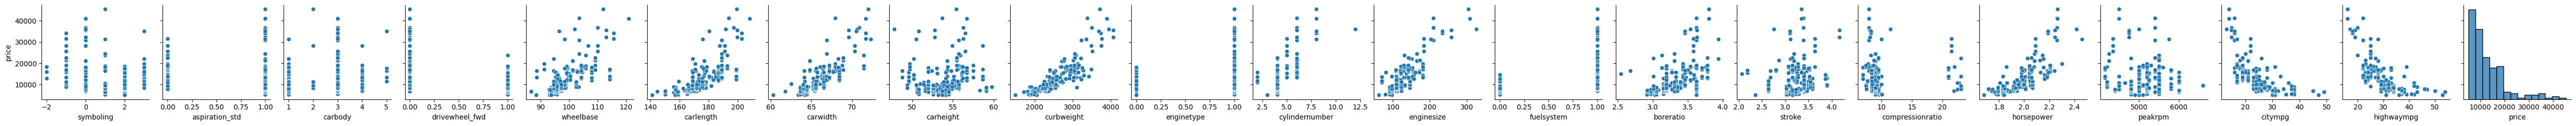

In [375]:
sns.pairplot(data=data.to_pandas(),y_vars="price")

In [376]:
cols=['symboling','wheelbase','carlength','carwidth','carheight','curbweight','enginetype','cylindernumber','enginesize','fuelsystem','boreratio'
      ,'stroke','compressionratio','horsepower','peakrpm','citympg','highwaympg','price']

# Binning

Mapping pink slip for symboling,cylindernumber as 0,1,2

In [377]:
df=data.with_columns(data["symboling"].replace({-3:1,-2:1,-1:1,0:0,1:0,2:0,3:0}))
df=df.with_columns(df['cylindernumber'].replace({2:0,3:0,4:0,5:1,6:1,8:2}))

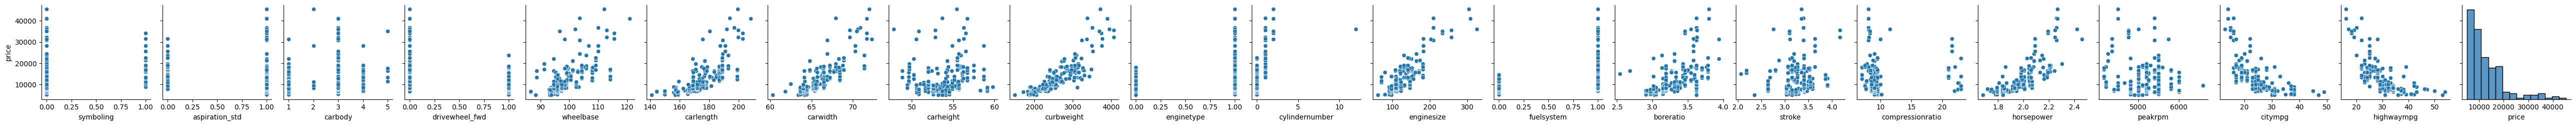

In [378]:
sns.pairplot(data=df.to_pandas(),y_vars="price")

In [379]:
df=df.drop("symboling")
df=df.drop("aspiration_std")
df=df.drop("carbody")
data=data.drop("symboling")
data=data.drop("aspiration_std")
data=data.drop("carbody")
cols.remove("symboling")

Mostly depending on fuel system

Combine engine related terms

In [380]:
import plotly.express as px
px.scatter(x=(df['peakrpm']*df['horsepower']*df["enginesize"]*df["boreratio"]),y=df['price'],color=df['price'])

<AxesSubplot: >

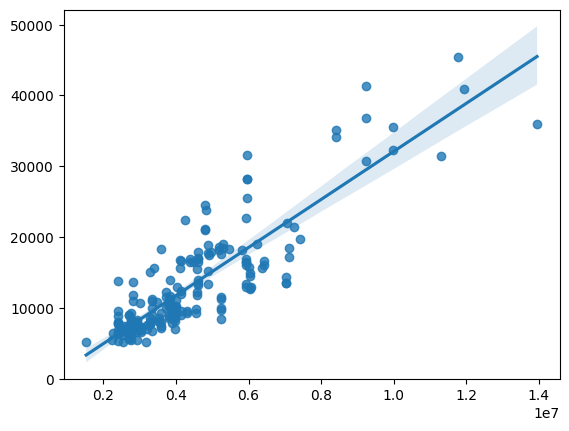

In [381]:
sns.regplot(x=(df['peakrpm']*df['horsepower']*df["enginesize"]*df["boreratio"]),y=df['price'])

Combining dimensions related columns

In [382]:
px.scatter(x=(df['carlength']*df['carwidth']*df['carheight']),y=df['price'],color=df['price'])

<AxesSubplot: >

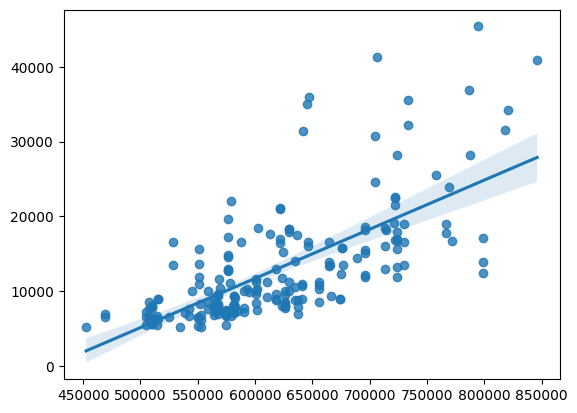

In [383]:
sns.regplot(x=(df['carlength']*df['carwidth']*df['carheight']),y=df['price'])

Dropping the far away point

In [384]:
data=data.with_columns(data['cylindernumber'].replace({2:0,3:0,4:0,5:1,6:1,8:1,12:1}))

data=data.with_columns(((data['carlength']*data['carwidth']*data["carheight"])).alias("carvolume")).drop("carlength", "carwidth","carheight")
data=data.with_columns(((data['peakrpm']*data['horsepower']*data["enginesize"]*data["boreratio"])).alias("enginepower")).drop("boreratio", "stroke","peakrpm","horsepower","enginesize")

# US Environmental Protection Agency (EPA) uses a standard weighting of 55% city and 45% highway to calculate a combined fuel economy rating for vehicles https://www.epa.gov/fueleconomy
data=data.with_columns(((data['citympg']*.55+data['highwaympg']*.45)).alias("averagempg")).drop("citympg",'highwaympg')

cols.remove("carwidth")
cols.remove("carheight")
cols.remove("carlength")
cols.remove("boreratio")
cols.remove("stroke")
cols.remove("peakrpm")
cols.remove("horsepower")
cols.remove("enginesize")
cols.remove("citympg")
cols.append("carvolume")
cols.append("enginepower")
cols.append("avgmpg")

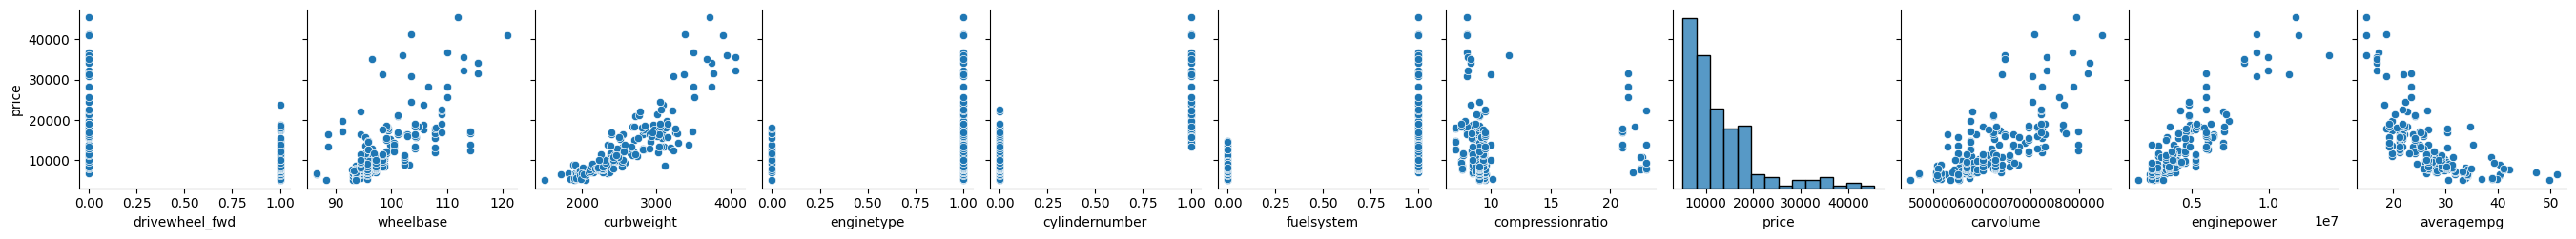

In [385]:
sns.pairplot(data=data.to_pandas(),y_vars="price")

# Having more domain knowledge may even make use of these remaining features like compression ratio,enginetype

<AxesSubplot: >

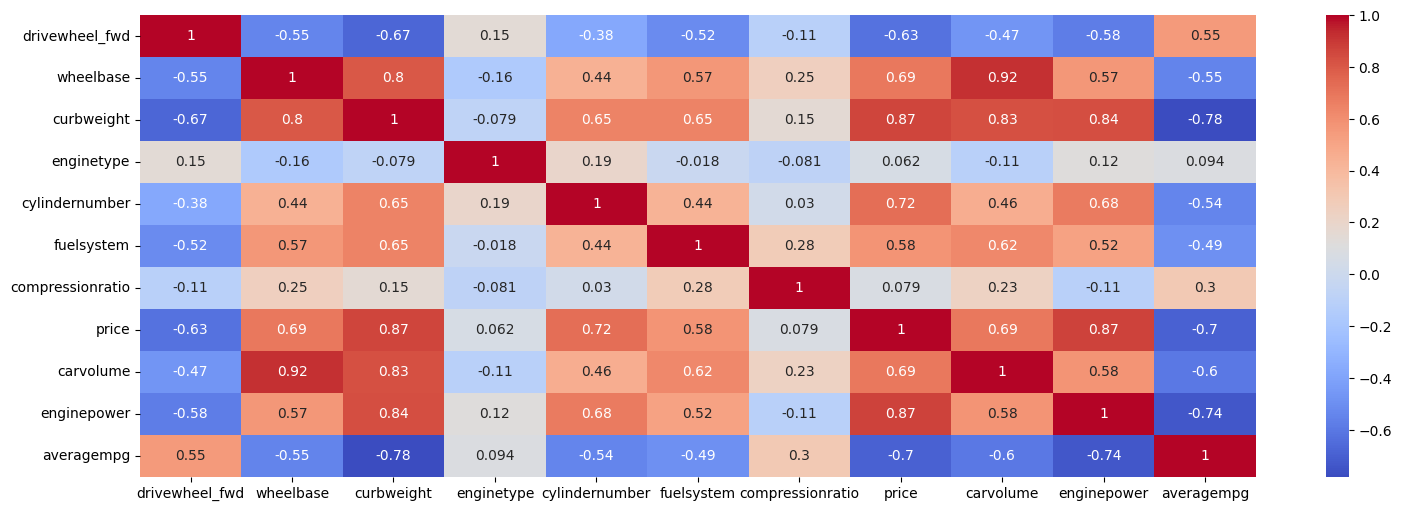

In [386]:
plt.figure(figsize=(18,6))
sns.heatmap(data.to_pandas().corr(),annot=True,cmap='coolwarm')

In [387]:
data=data.drop(["compressionratio","enginetype","fuelsystem","wheelbase","drivewheel_fwd"])
cols.remove("compressionratio")
cols.remove("enginetype")
cols.remove("fuelsystem")
cols.remove("wheelbase")

In [388]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

df = sm.add_constant(data.drop("price").to_pandas())
calculate_vif(df).sort_values(by='VIF',ascending=False).head()

,variables,VIF
0,const,221.444597
1,curbweight,9.478468
4,enginepower,4.311898
3,carvolume,3.692810
5,averagempg,2.750668


In [389]:
data.write_csv("../Day4_ErrorAnalysis/featureEngineered.csv")

Test Scores: [0.83409983 0.85156948 0.82409121]
Training Scores: [0.85421469 0.85075627 0.86504919]
Mean Test Score: 0.8365868409284816
Standard Deviation of Test Scores: 0.011354961335585239
Mean absolute Error: 2626.958096532359
R-squared: 0.8178793842904633


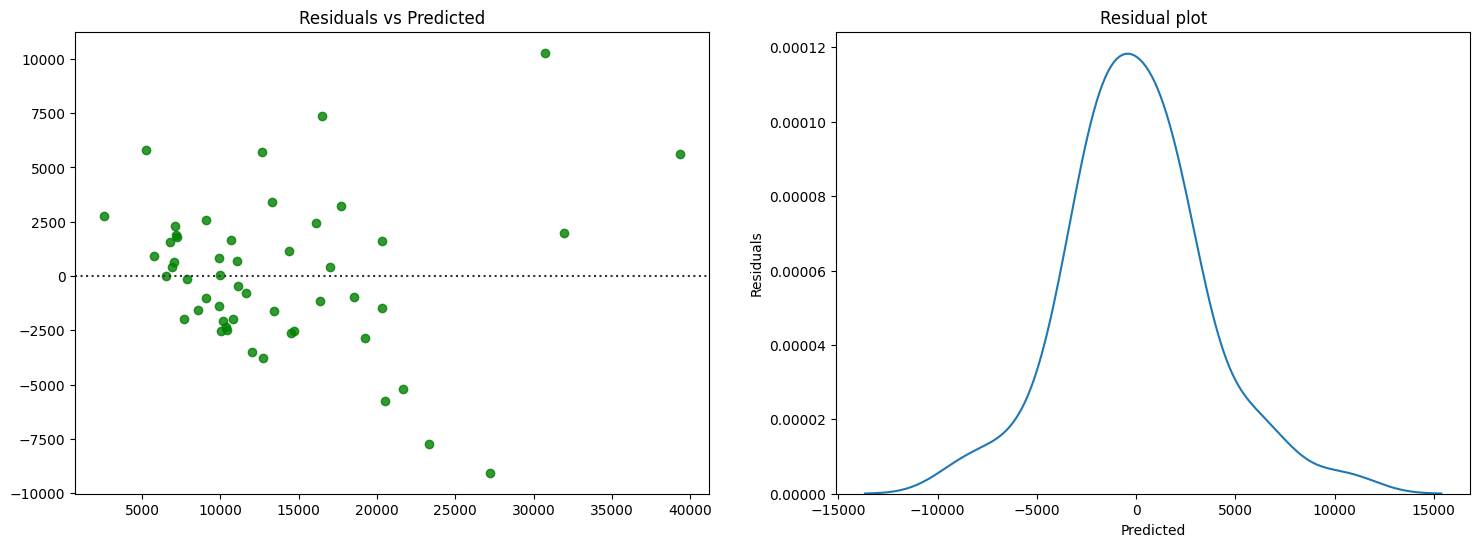

In [390]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
X_train, X_test, y_train, y_test = train_test_split(data.drop("price"),data["price"],test_size=0.25,random_state=0)
lr=LinearRegression()

kf=KFold(n_splits=3)
cv_results = cross_validate(lr, X_train,y_train, cv=kf, scoring='r2', return_train_score=True)
print(f'Test Scores: {cv_results["test_score"]}')
print(f'Training Scores: {cv_results["train_score"]}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error,r2_score

predictions = cross_val_predict(lr, X_test, y_test, cv=kf)
residuals = y_test - predictions
mse = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean absolute Error: {mse}')
print(f'R-squared: {r2}')

fig,[ax1,ax2] = plt.subplots(ncols=2,figsize=(18,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(residuals,ax=ax2)
ax2.set_title("Residual plot")
plt.show()

# mean test score changed from 82 to 83 (not much)

Residual range decreased little bit

### R2 score increased from 64 to 81 and mean_absolute_error descreased from 3250 to 2626